In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import os
import sys
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt    
import re
import pickle
import matplotlib.patches as mpatches
from statsmodels.graphics.mosaicplot import mosaic
from tabulate import tabulate
import seaborn as sns

sys.path.insert(1, '../')
from Prepare_Events_Functions import *
from Plot_events_functions import *

In [25]:
# Define a function to extract the month from the first timestamp
def extract_month(timestamps):
    # Check if timestamps is a valid array-like object
    if isinstance(timestamps, (np.ndarray, list)) and len(timestamps) > 0:
        # Check if the first element is not None and not NaN
        first_timestamp = timestamps[0]
        if pd.notna(first_timestamp):
            try:
                # Convert to datetime object
                datetime_obj = pd.to_datetime(first_timestamp)
                # Extract month
                return datetime_obj.month
            except (ValueError, TypeError):
                return np.nan  # Return NaN if conversion fails
    return np.nan 

def create_single_variable_mosaic_plot_pctlabels(ax, data, split_variable, order, color_mapping, title, filter_events=True):
    if filter_events == True:
         data= data[data['irain_profile_12'].notnull()]
            
    # Count the occurrences and reshape for mosaic plot
    count_data = data[split_variable].value_counts().reindex(order, fill_value=0)
    
    # Convert to dictionary format suitable for mosaic plot
    mosaic_data = count_data.to_dict()
    
    # Function to specify properties including colors based on cross_variable
    def props(key):
        # Extract category from key if it's a tuple
        if isinstance(key, tuple):
            category = key[0]  # Extract the first element from the tuple
        else:
            category = key  # Use directly if it's not a tuple
        color = color_mapping.get(category, (0.0, 0.0, 0.0, 0.6))  # Default to black if not found
        return {'color': color}
    
    # Calculate total number of occurrences for percentage calculation
    total_count = count_data.sum()
    
    # Plot the mosaic plot with automatic labels
    labelizer = lambda key: ''
    fig, rects = mosaic(mosaic_data, title='', labelizer = labelizer, properties=props, ax=ax, gap=0.015, horizontal=True)
    ax.invert_yaxis()  # Optional: Invert y-axis to match standard bar plot orientation
    ax.set_xticklabels([])  # Remove x-axis labels

    # Manually replace the labels with percentage labels
    counter=0
    for key, (x1, y1, x2, y2) in rects.items():
        count = mosaic_data[key[0]]
        percentage = (count / total_count) * 100
        label = f'{percentage:.2f}%'
        #print(counter)
        # Find the label at this position and replace its text
        for text in ax.texts:
            if counter in [0,6,12,18,24]:
                text.set_text(label)
                text.set_fontsize(10)
                text.set_color('black')
#                 text.set_weight('bold')
            counter=counter+1
            
        #print(f'Key: {key}, count {count} Percentage: {percentage:.2f}%, Label: {label}, x1: {x1}, x2: {x2}, y1: {y1}, y2: {y2}')

    for key, (x1, y1, x2, y2) in rects.items():
        if x1 == 0:  # Check if this is the leftmost bar
            ax.text(x1-0.01, (y1 + y2) / 2, title, va='center', ha='right', fontsize=15, color='black', weight='bold')    
            
def map_to_time_period(source):
    return present_future_lookup[source]            

In [3]:
color_mapping_loading = {
    'F2': (0.0, 0.0, 1.0, 0.6),    # darkblue with 0.6 alpha
    'F1': (0.0, 0.6902, 1.0, 0.6), # deepskyblue with 0.6 alpha
    'C': (0.5, 0.5, 0.5, 0.6),     # grey with 0.6 alpha
    'B1': (0.8039, 0.0, 0.0, 0.6), # indianred with 0.6 alpha
    'B2': (0.5451, 0.0, 0.0, 0.6)}  # darkred with 0.6 alpha

color_mapping_seasons = {
    'Summer': (1.0, 0.6471, 0.0, 0.6), # orange with 0.6 alpha
    'Winter': (0.0, 0.0, 1.0, 0.6)}     # blue with 0.6 alpha}

quintile_mapping = {1: 'F2', 2: 'F1', 3: 'C', 4: 'B1', 5: 'B2'}
quintile_cats_loading = ['F2','F1', 'C', 'B1', 'B2']
n= 5
quintile_cats_season = ['Winter', 'Summer']    

present_future_lookup = {
    'bc005': 'Present',
    'bc006': 'Present',
    'bc007': 'Present',
    'bc009': 'Present',
    'bc010': 'Present',
    'bc016': 'Present',
    'bc017': 'Present',
    'bc018': 'Present',
    'nimrod': 'NIMROD',
    'bb189': 'Future',
    'bb198': 'Future'}

# Read in data
For events with n data points which is a multiple of 5

ADD THIS dataframes['bc006']['Loading_profile_molly'] = dataframes['bc006']['max_quintile_molly'].map(quintile_mapping)

In [17]:
# Define the list of identifiers
ids = ['nimrod', 
       'bc005', 'bc006', 'bc007', 'bc009', 'bc010', 'bc016', 'bc017', 'bc018',
       'bb189', 'bb198']

# Define the corresponding labels for each identifier
labels = ['NIMROD',
    'UKCP18_present (BC005)', 'UKCP18_present (BC006)', 'UKCP18_present (BC007)',
    'UKCP18_present (BC009)', 'UKCP18_present (BC010)', 'UKCP18_present (BC016)',
    'UKCP18_present (BC017)', 'UKCP18_present (BC018)',
    'UKCP18_future (BB189)', 'UKCP18_future (BB198)']

In [14]:
# Dictionary to store the dataframes
dataframes = {}
dataframes_summer = {}
dataframes_shortdurations = {}
dataframes_longdurations = {}
dataframes_divisible_by5 = {}
dataframes_inclnulls = {}

for id in ids:
    
    if present_future_lookup[id] == 'Present':
        file_path = f"/nfs/a319/gy17m2a/PhD/ProcessedData/Profiles/UKCP18_30mins/Present/{id}/df_withoutnulls.pkl"
        file_path_inclnulls = f"/nfs/a319/gy17m2a/PhD/ProcessedData/Profiles/UKCP18_30mins/Present/{id}/df.pkl"
    elif present_future_lookup[id] == 'Future':
        file_path = f"/nfs/a319/gy17m2a/PhD/ProcessedData/Profiles/UKCP18_30mins/Future/{id}/df_withoutnulls.pkl"
        file_path_inclnulls = f"/nfs/a319/gy17m2a/PhD/ProcessedData/Profiles/UKCP18_30mins/Future/{id}/df.pkl"
    elif present_future_lookup[id] == 'NIMROD' :  
        file_path = f"/nfs/a319/gy17m2a/PhD/ProcessedData/Profiles/NIMROD_30mins/WholeYear/NIMROD_2.2km_filtered_100_df_withoutnulls.pkl"
        file_path_inclnulls = f"/nfs/a319/gy17m2a/PhD/ProcessedData/Profiles/NIMROD_30mins/WholeYear/NIMROD_2.2km_filtered_100_df.pkl"
    
    # Load the dataframe from the pickle file
    with open(file_path, 'rb') as f:
        df = pickle.load(f)
    
    # Apply the month extraction function
    df['month'] = df['times'].apply(extract_month)
    df['Loading_profile_steef'] =df['max_quintile_steef'].map(quintile_mapping)
    
    # Store the dataframe in the dictionary with the id as the key
    dataframes[id] = df
    dataframes_divisible_by5[id]  = df[df['precip'].apply(is_multiple_of_5)]
    dataframes_summer[id] = df[df["season"]=='Summer']
    dataframes_shortdurations[id] = df[df["duration"]<6]
    dataframes_longdurations[id] = df[df["duration"]>=6]
        
    ###############################
    ########## Data including Nulls
    ###############################
    # Load the dataframe from the pickle file
    with open(file_path_inclnulls, 'rb') as f:
        df = pickle.load(f)
    dataframes_inclnulls[id] = df

In [15]:
for key, df in dataframes.items():
    print(f"There are {len(df)} of {key} (and {len(df)/19})")

There are 87931 of nimrod (and 4627.9473684210525)
There are 119369 of bc005 (and 6282.578947368421)
There are 114092 of bc006 (and 6004.8421052631575)
There are 113692 of bc007 (and 5983.789473684211)
There are 110583 of bc009 (and 5820.1578947368425)
There are 111837 of bc010 (and 5886.1578947368425)
There are 115173 of bc016 (and 6061.736842105263)
There are 169562 of bc017 (and 8924.315789473685)
There are 114853 of bc018 (and 6044.894736842105)
There are 111827 of bb189 (and 5885.631578947368)
There are 107246 of bb198 (and 5644.526315789473)


### Mosaic plot comparing seasons

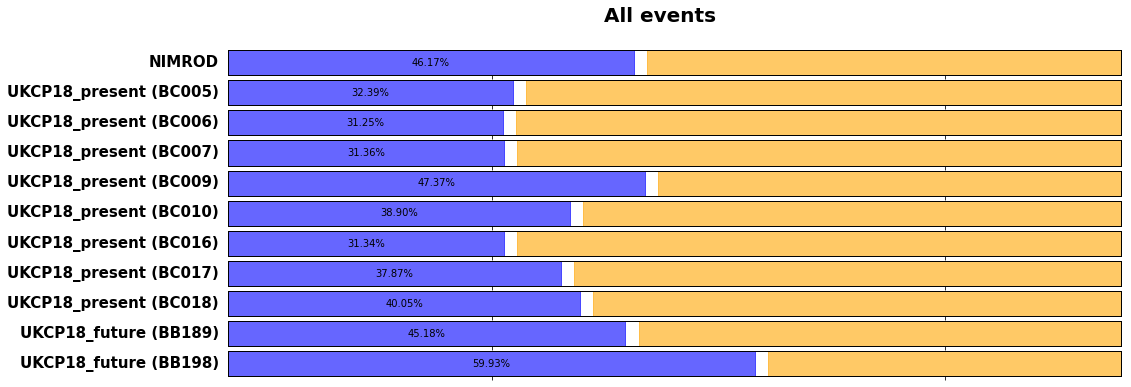

In [18]:
# Create the subplots
fig, axs = plt.subplots(nrows=len(ids), figsize=(16, 6), sharex=True)

# Loop over each id and create the plots
for i, id in enumerate(ids):
    create_single_variable_mosaic_plot_pctlabels(
        axs[i], dataframes[id], 'season', 
        quintile_cats_season, color_mapping_seasons, 
        labels[i], True)

# Add the overall title
fig.suptitle('All events', fontweight="bold", fontsize=20);

### Mosaic plot comparing loading

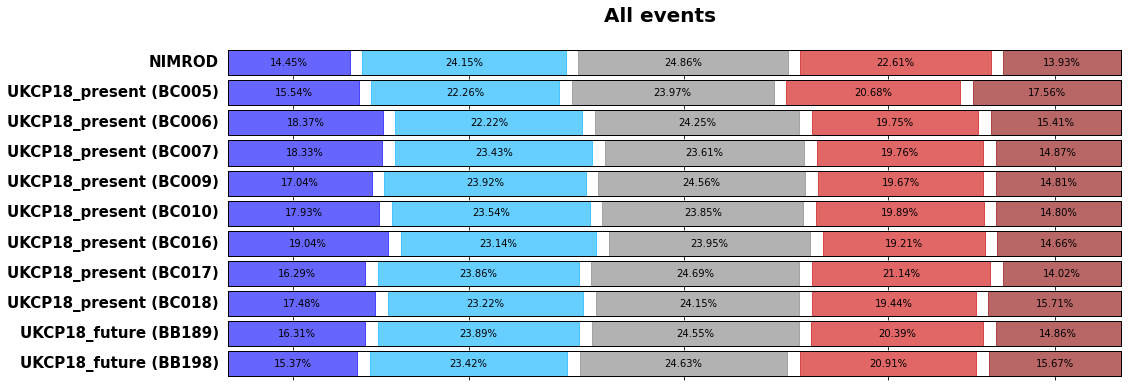

In [19]:
# Create the subplots
fig, axs = plt.subplots(nrows=len(ids), figsize=(16, 6), sharex=True)

# Loop over each id and create the plots
for i, id in enumerate(ids):
    create_single_variable_mosaic_plot_pctlabels(
        axs[i], dataframes[id], 'Loading_profile_molly', 
        quintile_cats_loading, color_mapping_loading, 
        labels[i], True)

# Add the overall title
fig.suptitle('All events', fontweight="bold", fontsize=20);

### Season mosaic plot with both present and future

In [ ]:
# Define your color mapping for seasons and time periods
color_mapping_seasons_timeperiods = {
    'Summer_Future': (1.0, 0.6471, 0.0, 0.6),
    'Summer_Present': (1.0, 0.6471, 0.0, 0.6),  
    'Winter_Future': (0.0, 0.0, 1.0, 0.6),    
    'Winter_Present': (0.0, 0.0, 1.0, 0.6)}

# Sample dataframes (replace these with your actual DataFrames)
dataframes = {
    'Summer_Present': pd.DataFrame({'Season': ['Summer']*100, 'Percentage': [10 + i*0.5 for i in range(100)]}),
    'Summer_Future': pd.DataFrame({'Season': ['Summer']*100, 'Percentage': [12 + i*0.5 for i in range(100)]}),
    'Winter_Present': pd.DataFrame({'Season': ['Winter']*100, 'Percentage': [15 + i*0.5 for i in range(100)]}),
    'Winter_Future': pd.DataFrame({'Season': ['Winter']*100, 'Percentage': [17 + i*0.5 for i in range(100)]}),
}

# Create a combined DataFrame
combined_df = pd.concat(dataframes, names=['Season_TimePeriod'])

In [116]:
combined_df_present = combined_df[combined_df['TimePeriod']=='Present']
combined_df_future = combined_df[combined_df['TimePeriod']=='Future']

In [26]:
combined_data = []
split_variable = 'season'
df = dataframes_inclnulls
for member in ids[1:]:
    df = dataframes[member][split_variable].value_counts(normalize=True).reset_index()
    df.columns = [split_variable, 'Percentage']
    df['Percentage'] *= 100  # Convert to percentage
    df['Source'] = member  # Label the source
    combined_data.append(df)
combined_df = pd.concat(combined_data)
combined_df['TimePeriod'] = combined_df['Source'].apply(map_to_time_period)
combined_df['Season_TimePeriod'] = combined_df['season'] + '_' + combined_df['TimePeriod']
combined_df = combined_df.reset_index(level=0, drop=True)

ordered_categories = [
    'Summer_Present', 'Summer_Future',
    'Winter_Present', 'Winter_Future']

In [28]:
combined_df

,season,Percentage,Source,TimePeriod,Season_TimePeriod
0,Summer,67.609681,bc005,Present,Summer_Present
1,Winter,32.390319,bc005,Present,Winter_Present
2,Summer,68.754163,bc006,Present,Summer_Present
3,Winter,31.245837,bc006,Present,Winter_Present
4,Summer,68.642473,bc007,Present,Summer_Present
5,Winter,31.357527,bc007,Present,Winter_Present
6,Summer,52.631055,bc009,Present,Summer_Present
7,Winter,47.368945,bc009,Present,Winter_Present
8,Summer,61.103213,bc010,Present,Summer_Present
9,Winter,38.896787,bc010,Present,Winter_Present


In [30]:
# # Plotting
# fig, ax = plt.subplots(figsize=(12, 8))

# # Create the box plot
# sns.boxplot(
#     x='Season_TimePeriod', y='Percentage',
#     data=combined_df, ax=ax,
#     order=ordered_categories,
#     palette=color_mapping_seasons_timeperiods
# )

# # Add titles and labels
# ax.set_title('Comparison of Seasonal Percentages between Present and Future', fontsize=16, fontweight='bold')
# ax.set_xlabel('Season and Time Period')
# ax.set_ylabel('Percentage (%)')

# # Adjust x-axis labels for better readability
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# # Display the plot
# plt.show()

In [107]:
present_ls = [key for key, item in present_future_lookup.items() if item == 'Present']
present_df = pd.concat([dataframes[key] for key in present_ls], axis=0)

future_ls = [key for key, item in present_future_lookup.items() if item == 'Future']
future_df = pd.concat([dataframes[key] for key in future_ls], axis=0)

In [ ]:
# https://stackoverflow.com/questions/65709684/grouping-boxplots-in-seaborn-coming-from-multiple-dataframes

In [ ]:
# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="season", y="Percentage",
            hue="TimePeriod", palette=["m", "g"],
            data=df)
# sns.despine(offset=10, trim=True)

<AxesSubplot:xlabel='season', ylabel='Percentage'>

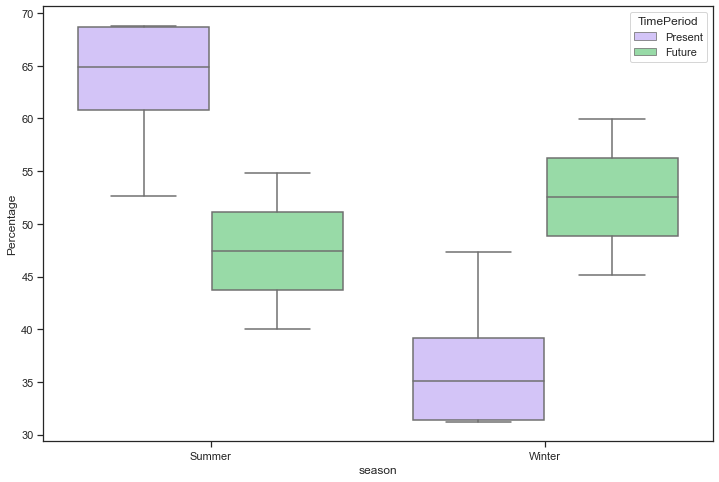

In [220]:
import seaborn as sns
sns.set_theme(style="ticks", palette="pastel")

# Load the example tips dataset
tips = sns.load_dataset("tips")
fig, ax = plt.subplots(figsize=(12, 8))
# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="season", y="Percentage",
            hue="TimePeriod", palette=["m", "g"],
            data=df)
# sns.despine(offset=10, trim=True)

In [ ]:
# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="season", y="Percentage",
            hue=" ", palette=["m", "g"],
            data=tips)

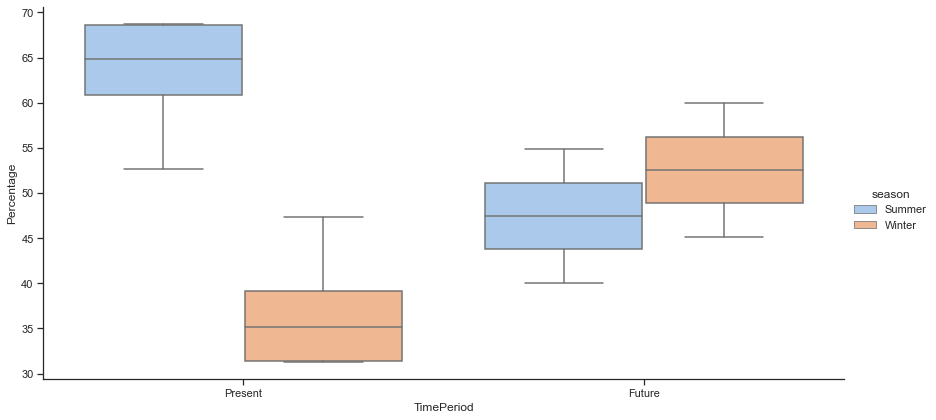

In [219]:
g = sns.catplot(kind='box', data=df, x='TimePeriod', y='Percentage', hue='season', height=6, aspect=2)
# sns.despine(offset=12, trim=True)

/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/ukcp18/lib/python3.7/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

ValueError: Could not interpret input 'Category_Source'

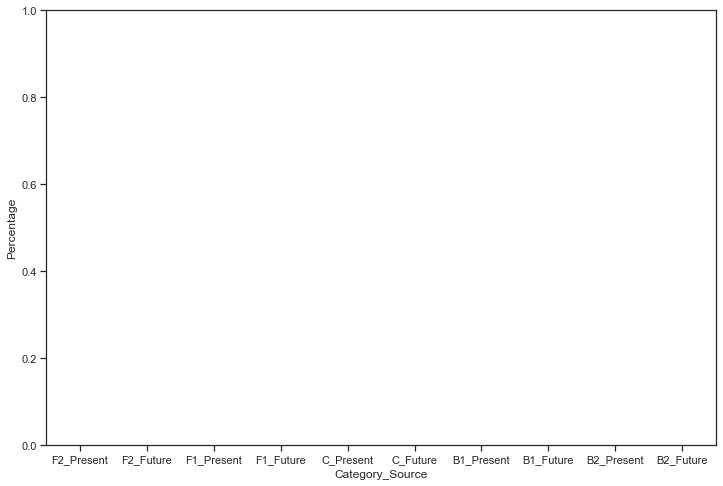

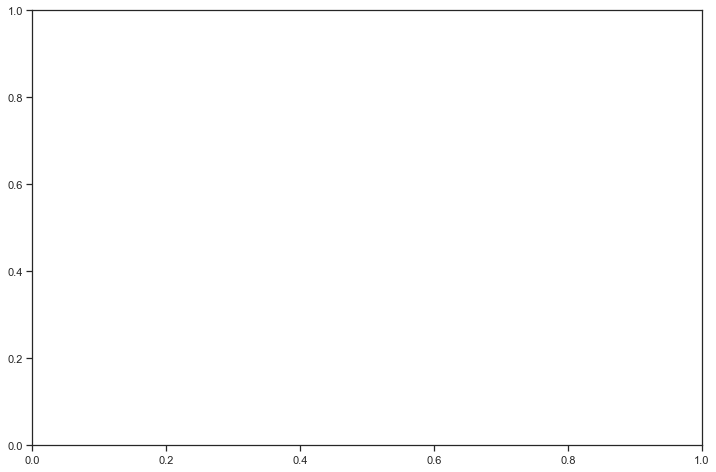

In [233]:

# Prepare the combined DataFrame with percentages
# combined_df = prepare_combined_data(dataframes, 'Loading_profile_molly', ids)
combined_df =combined_df[combined_df['Source']!='nimrod'] 
# Define the color mapping for present and future with transparency
color_mapping = {
    'F2_Present': (0.0, 0.0, 1.0, 0.6),
    'F2_Future': (0.0, 0.0, 1.0, 0.3),
    'F1_Present': (0.0, 0.6902, 1.0, 0.6),
    'F1_Future': (0.0, 0.6902, 1.0, 0.3),
    'C_Present': (0.5, 0.5, 0.5, 0.6),  
    'C_Future': (0.5, 0.5, 0.5, 0.3),  
    'B1_Present': (0.8039, 0.0, 0.0, 0.6),
    'B1_Future': (0.8039, 0.0, 0.0, 0.3),
    'B2_Present': (0.5451, 0.0, 0.0, 0.6),
    'B2_Future': (0.5451, 0.0, 0.0, 0.3)
}

# Ensure the Loading_profile_molly column is treated as a string
combined_df['Loading_profile_molly'] = combined_df['Loading_profile_molly'].astype(str)

# Create a new column combining Loading_profile_molly and Source for color mapping
combined_df['Category_Source'] = combined_df['Loading_profile_molly'] + '_' + combined_df['Source']

# Define ordered categories and their x-axis positions
ordered_categories = [
    'F2_Present', 'F2_Future', 
    'F1_Present', 'F1_Future',
    'C_Present', 'C_Future',
    'B1_Present', 'B1_Future',
    'B2_Present', 'B2_Future'
]

# Map categories to positions
category_to_pos = {cat: idx for idx, cat in enumerate(ordered_categories)}
present_categories = [cat for cat in ordered_categories if 'Present' in cat]


# Define the color mapping for present and future with transparency
color_mapping = {
    'F2_Present': (0.0, 0.0, 1.0, 0.6),
    'F2_Future': (0.0, 0.0, 1.0, 0.3),
    'F1_Present': (0.0, 0.6902, 1.0, 0.6),
    'F1_Future': (0.0, 0.6902, 1.0, 0.3),
    'C_Present': (0.5, 0.5, 0.5, 0.6),  
    'C_Future': (0.5, 0.5, 0.5, 0.3),  
    'B1_Present': (0.8039, 0.0, 0.0, 0.6),
    'B1_Future': (0.8039, 0.0, 0.0, 0.3),
    'B2_Present': (0.5451, 0.0, 0.0, 0.6),
    'B2_Future': (0.5451, 0.0, 0.0, 0.3)
}

# Ensure the Loading_profile_molly column is treated as a string
combined_df['Loading_profile_molly'] = combined_df['Loading_profile_molly'].astype(str)

# Create a new column combining Loading_profile_molly and Source for color mapping
combined_df['Category_Source'] = combined_df['Loading_profile_molly'] + '_' + combined_df['Source']

# Define ordered categories and their x-axis positions
ordered_categories = [
    'F2_Present', 'F2_Future', 
    'F1_Present', 'F1_Future',
    'C_Present', 'C_Future',
    'B1_Present', 'B1_Future',
    'B2_Present', 'B2_Future'
]

# Map categories to positions
category_to_pos = {cat: idx for idx, cat in enumerate(ordered_categories)}
present_categories = [cat for cat in ordered_categories if 'Present' in cat]

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Create the box plot with custom colors
bar = sns.boxplot(
    x='Category_Source', y='Percentage',
    data=combined_df, ax=ax, 
    order=ordered_categories, palette=color_mapping, 
    showmeans=False
)

fig, ax = plt.subplots(figsize=(12, 8))
# Draw a nested boxplot to show bills by day and time
sns.boxplot(x="Category_Source", y="Percentage",
            hue="TimePeriod", palette=["m", "g"],
            data=df)


# # Define some hatches
# hatches = ['//', '', '||', '', '||', '', '||', '','||', '']

# # Loop over the bars
# for i,thisbar in enumerate(bar.patches):
#     # Set a different hatch for each bar
#     thisbar.set_hatch(hatches[i])


# # Overlay the Nimrod values as percentage points
# nimrod_data = dataframes['nimrod']['Loading_profile_molly'].value_counts(normalize=True).reindex(quintile_cats_loading, fill_value=0)
# nimrod_values = nimrod_data.index
# nimrod_percentages = nimrod_data.values * 100  # Convert to percentage

# # Plot Nimrod values aligned with 'Present' categories
# for category in present_categories:
#     if category in nimrod_values:
#         i = category_to_pos[category]
#         nimrod_percentage = nimrod_percentages[nimrod_values.get_loc(category)]
#         ax.scatter(i, nimrod_percentage, color='red', s=100, zorder=5, marker='X')

# # Add titles and labels
# ax.set_title('Comparison of Loading Profiles between UKCP18 Ensembles and NIMROD', fontsize=16, fontweight='bold')
# ax.set_xlabel('Loading Profile')
# ax.set_ylabel('Percentage of Events (%)')

# # Ensure legend includes 'NIMROD' if it hasn't been added yet
# handles, labels = ax.get_legend_handles_labels()
# if 'NIMROD' not in labels:
#     ax.legend(handles + [plt.Line2D([0], [0], marker='X', color='w', markerfacecolor='red', markersize=10, label='NIMROD')], labels + ['NIMROD'])

# # Adjust x-axis labels for better readability
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# # Display the plot
# plt.show()


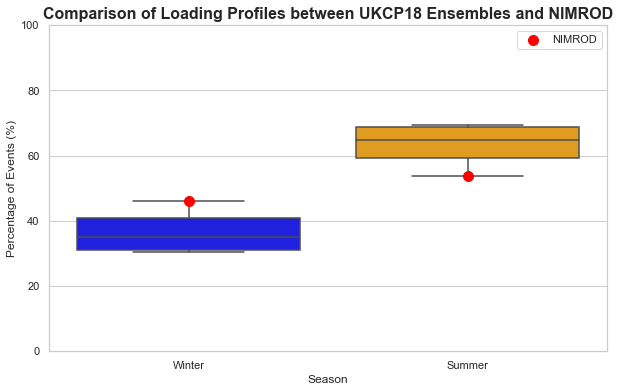

In [93]:
# Function to calculate percentages for each ensemble member
def prepare_combined_data(dataframes, split_variable, ensemble_members):
    combined_data = []
    for member in ensemble_members:
        # Calculate frequency and then normalize to get percentage
        df = dataframes[member][split_variable].value_counts(normalize=True).reset_index()
        df.columns = [split_variable, 'Percentage']
        df['Percentage'] *= 100  # Convert to percentage
        df['Source'] = member  # Label the source
        combined_data.append(df)
    
    combined_df = pd.concat(combined_data)
    return combined_df

# List of ensemble members to compare
ensemble_members = ['bc005', 'bc006', 'bc009', 'bc018']

# Prepare the combined DataFrame with percentages
combined_df = prepare_combined_data(dataframes_inclnulls, 'season', ensemble_members)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Create the box plot for the UKCP18 ensemble members' percentages
sns.boxplot(x='season', y='Percentage', data=combined_df, ax=ax, 
            order=quintile_cats_season, palette=color_mapping_seasons, showmeans=False)

# Overlay the Nimrod values as percentage points
nimrod_data = dataframes['nimrod']['season'].value_counts(normalize=True).reindex(quintile_cats_season, fill_value=0)
nimrod_values = nimrod_data.index
nimrod_percentages = nimrod_data.values * 100  # Convert to percentage

# Plot the Nimrod values
for i, category in enumerate(nimrod_values):
    nimrod_percentage = nimrod_percentages[i]
    ax.scatter(i, nimrod_percentage, color='red', s=100, zorder=5, label='NIMROD' if i == 0 else "")

# Add titles and labels
ax.set_title('Comparison of Loading Profiles between UKCP18 Ensembles and NIMROD', fontsize=16, fontweight='bold')
ax.set_xlabel('Season')
ax.set_ylabel('Percentage of Events (%)')
ax.set_ylim(0,100)
plt.legend()

# Display the plot
plt.show()


### Combine present and future into one dataframe

In [224]:
def prepare_combined_data(dataframes, split_variable, ensemble_members):
    combined_data = []
    for member in ensemble_members:
        # Calculate frequency and then normalize to get percentage
        df = dataframes[member][split_variable].value_counts(normalize=True).reset_index()
        df.columns = [split_variable, 'Percentage']
        df['Percentage'] *= 100  # Convert to percentage
        df['Source'] = member  # Label the source
        combined_data.append(df)
    
    combined_df = pd.concat(combined_data)
    return combined_df

# List of ensemble members to compare
ensemble_members_present = ['bc005', 'bc006','bc007', 'bc009','bc010', 'bc016','bc017',  'bc018']
ensemble_members_future = ['bb189', 'bb198']

# Prepare the combined DataFrame with percentages
combined_df_present = prepare_combined_data(dataframes, 'Loading_profile_molly', ensemble_members_present)
combined_df_future = prepare_combined_data(dataframes, 'Loading_profile_molly', ensemble_members_future)

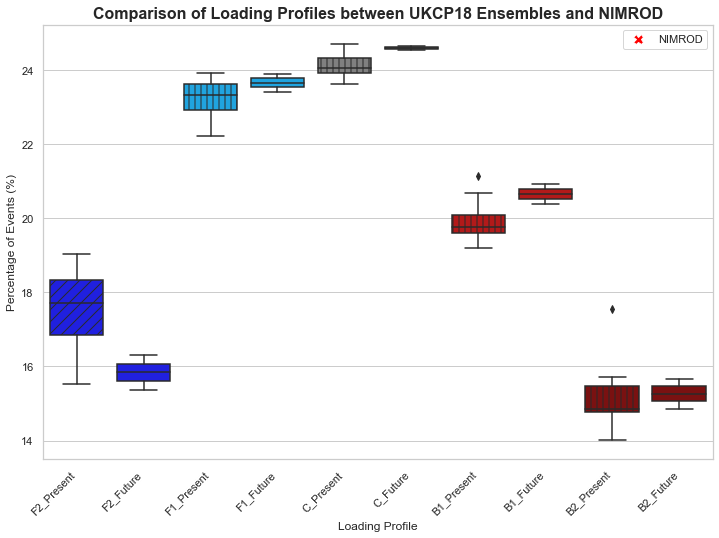

In [75]:

# Sample DataFrame (Replace with your actual DataFrame)
# combined_df = pd.DataFrame(...)

# Define the color mapping for present and future with transparency
color_mapping = {
    'F2_Present': (0.0, 0.0, 1.0, 0.6),
    'F2_Future': (0.0, 0.0, 1.0, 0.3),
    'F1_Present': (0.0, 0.6902, 1.0, 0.6),
    'F1_Future': (0.0, 0.6902, 1.0, 0.3),
    'C_Present': (0.5, 0.5, 0.5, 0.6),  
    'C_Future': (0.5, 0.5, 0.5, 0.3),  
    'B1_Present': (0.8039, 0.0, 0.0, 0.6),
    'B1_Future': (0.8039, 0.0, 0.0, 0.3),
    'B2_Present': (0.5451, 0.0, 0.0, 0.6),
    'B2_Future': (0.5451, 0.0, 0.0, 0.3)
}

# Ensure the Loading_profile_molly column is treated as a string
combined_df['Loading_profile_molly'] = combined_df['Loading_profile_molly'].astype(str)

# Create a new column combining Loading_profile_molly and Source for color mapping
combined_df['Category_Source'] = combined_df['Loading_profile_molly'] + '_' + combined_df['Source']

# Define ordered categories and their x-axis positions
ordered_categories = [
    'F2_Present', 'F2_Future', 
    'F1_Present', 'F1_Future',
    'C_Present', 'C_Future',
    'B1_Present', 'B1_Future',
    'B2_Present', 'B2_Future'
]

# Map categories to positions
category_to_pos = {cat: idx for idx, cat in enumerate(ordered_categories)}
present_categories = [cat for cat in ordered_categories if 'Present' in cat]

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Create the box plot with custom colors
bar = sns.boxplot(
    x='Category_Source', y='Percentage',
    data=combined_df, ax=ax, 
    order=ordered_categories, palette=color_mapping, 
    showmeans=False
)


# Define some hatches
hatches = ['//', '', '||', '', '||', '', '||', '','||', '']

# Loop over the bars
for i,thisbar in enumerate(bar.patches):
    # Set a different hatch for each bar
    thisbar.set_hatch(hatches[i])


# Overlay the Nimrod values as percentage points
nimrod_data = dataframes['nimrod']['Loading_profile_molly'].value_counts(normalize=True).reindex(quintile_cats_loading, fill_value=0)
nimrod_values = nimrod_data.index
nimrod_percentages = nimrod_data.values * 100  # Convert to percentage

# Plot Nimrod values aligned with 'Present' categories
for category in present_categories:
    if category in nimrod_values:
        i = category_to_pos[category]
        nimrod_percentage = nimrod_percentages[nimrod_values.get_loc(category)]
        ax.scatter(i, nimrod_percentage, color='red', s=100, zorder=5, marker='X')

# Add titles and labels
ax.set_title('Comparison of Loading Profiles between UKCP18 Ensembles and NIMROD', fontsize=16, fontweight='bold')
ax.set_xlabel('Loading Profile')
ax.set_ylabel('Percentage of Events (%)')

# Ensure legend includes 'NIMROD' if it hasn't been added yet
handles, labels = ax.get_legend_handles_labels()
if 'NIMROD' not in labels:
    ax.legend(handles + [plt.Line2D([0], [0], marker='X', color='w', markerfacecolor='red', markersize=10, label='NIMROD')], labels + ['NIMROD'])

# Adjust x-axis labels for better readability
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

# Display the plot
plt.show()


ValueError: Could not interpret input 'Loading_profile_molly'

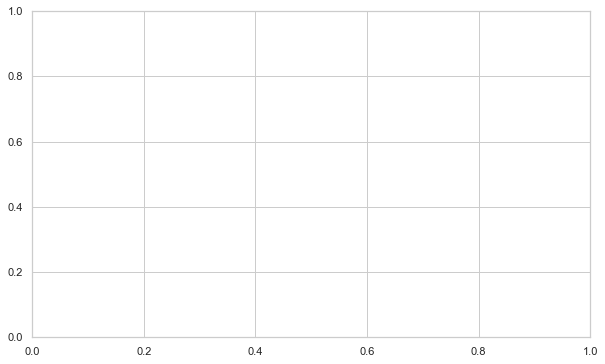

In [98]:
def prepare_combined_data(dataframes, split_variable, ensemble_members):
    combined_data = []
    for member in ensemble_members:
        # Calculate frequency and then normalize to get percentage
        df = dataframes[member][split_variable].value_counts(normalize=True).reset_index()
        df.columns = [split_variable, 'Percentage']
        df['Percentage'] *= 100  # Convert to percentage
        df['Source'] = member  # Label the source
        combined_data.append(df)
    
    combined_df = pd.concat(combined_data)
    return combined_df

# List of ensemble members to compare
ensemble_members_present = ['bc005', 'bc006','bc007', 'bc009','bc010', 'bc016','bc017',  'bc018']
ensemble_members_future = ['bb189', 'bb198']

# Prepare the combined DataFrame with percentages
combined_df_present = prepare_combined_data(dataframes, 'Loading_profile_molly', ensemble_members_present)
combined_df_future = prepare_combined_data(dataframes, 'Loading_profile_molly', ensemble_members_future)

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Create the box plot for the UKCP18 ensemble members' percentages
sns.boxplot(x='Loading_profile_molly', y='Percentage', data=combined_df, ax=ax, 
            order=quintile_cats_loading, palette=color_mapping_loading, showmeans=False)

# Overlay the Nimrod values as percentage points
nimrod_data = dataframes['nimrod']['Loading_profile_molly'].value_counts(normalize=True).reindex(quintile_cats_loading, fill_value=0)
nimrod_values = nimrod_data.index
nimrod_percentages = nimrod_data.values * 100  # Convert to percentage

# Plot the Nimrod values
for i, category in enumerate(nimrod_values):
    nimrod_percentage = nimrod_percentages[i]
    ax.scatter(i, nimrod_percentage, color='red', s=100, zorder=5, label='NIMROD' if i == 0 else "")

# Add titles and labels
ax.set_title('Comparison of Loading Profiles between UKCP18 Ensembles and NIMROD', fontsize=16, fontweight='bold')
ax.set_xlabel('Loading Profile')
ax.set_ylabel('Percentage of Events (%)')
plt.legend()

# Display the plot
plt.show()

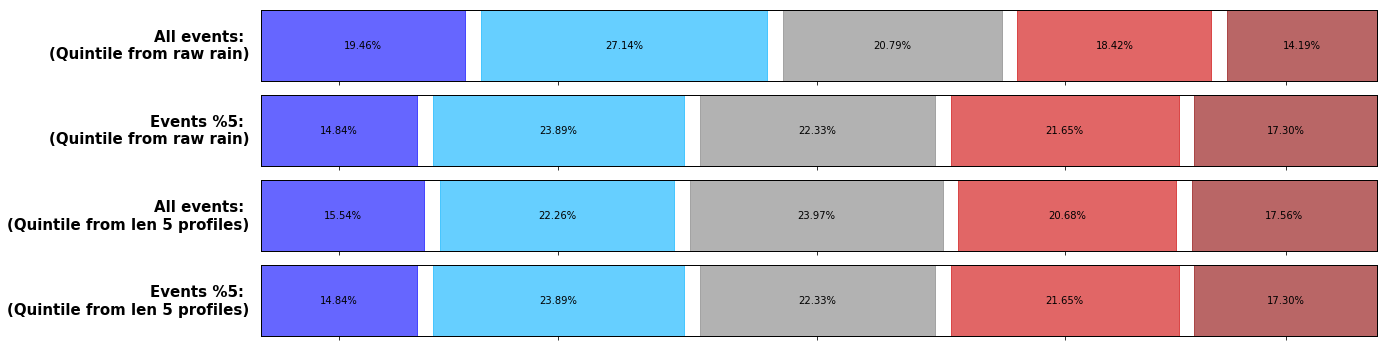

In [21]:
data = dataframes['bc005']
data_divisibleby5 = dataframes_divisible_by5['bc005']

fig, axs = plt.subplots(nrows=4, figsize=(20,6), sharex=True)
create_single_variable_mosaic_plot_pctlabels(axs[0], data,'Loading_profile_raw_rain',quintile_cats_loading, color_mapping_loading, 'All events: \n(Quintile from raw rain)', True)
create_single_variable_mosaic_plot_pctlabels(axs[1], data_divisibleby5, 'Loading_profile_raw_rain',quintile_cats_loading, color_mapping_loading, 'Events %5: \n(Quintile from raw rain)', True)
create_single_variable_mosaic_plot_pctlabels(axs[2], data, 'Loading_profile_steef',quintile_cats_loading, color_mapping_loading, 'All events: \n(Quintile from len 5 profiles)', True)
create_single_variable_mosaic_plot_pctlabels(axs[3], data_divisibleby5, 'Loading_profile_steef',quintile_cats_loading, color_mapping_loading, 'Events %5: \n(Quintile from len 5 profiles)', True);


## NIMROD and UKCP18 present seasonal split in different years

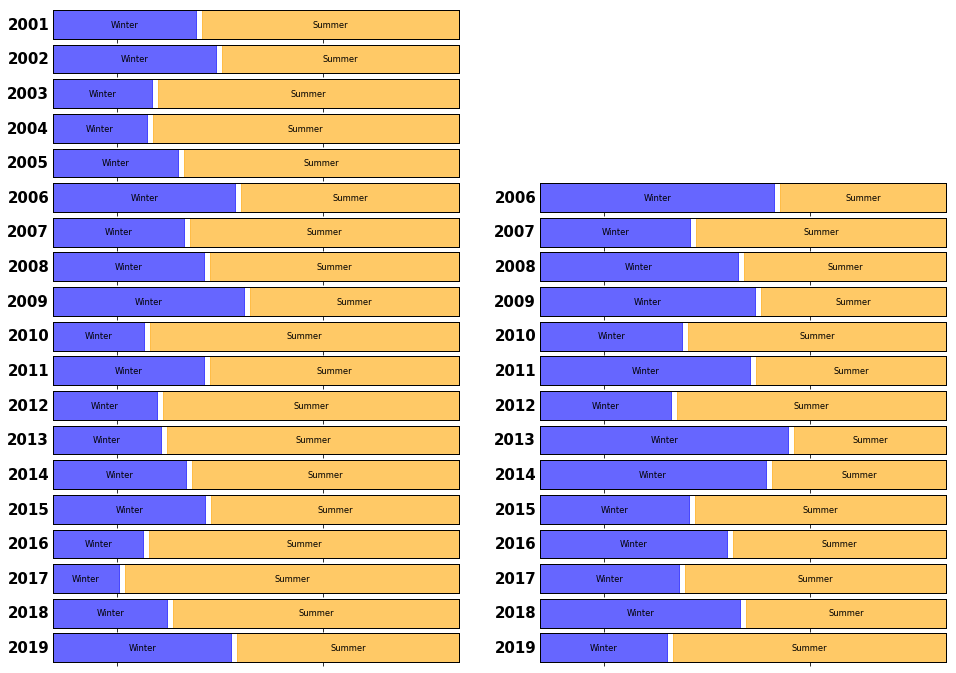

In [22]:
fig, axs = plt.subplots(nrows=19, ncols =2, figsize=(16, 12), sharex=True)
for number, year in enumerate(range(2001,2020)):
    trimmed = dataframes['bc005'][dataframes['bc005']['year'] == year]
    create_single_variable_mosaic_plot(axs[number, 0], trimmed, 'season', quintile_cats_season, color_mapping_seasons, year, False)
for number, year in enumerate(range(2001,2020)):
    if year in range(2001,2006):
        axs[number,1].remove()
    else:
        trimmed = dataframes['nimrod'][dataframes['nimrod']['year'] == year]
        create_single_variable_mosaic_plot(axs[number,1], trimmed, 'season', quintile_cats_season, color_mapping_seasons, year, False) 


# UKCP18 present and future

NameError: name 'bc005' is not defined

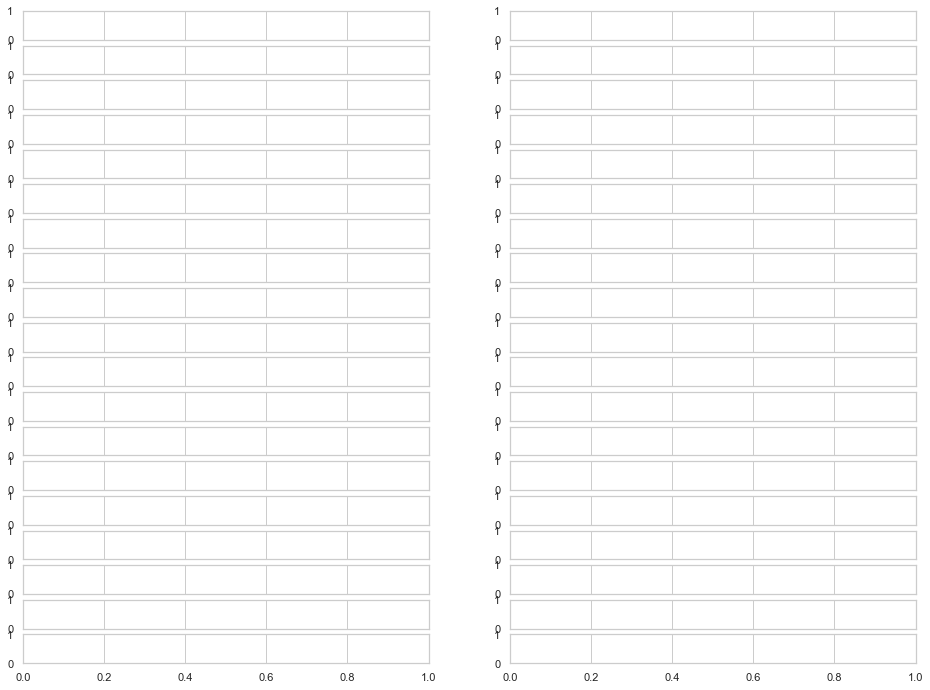

In [88]:
fig, axs = plt.subplots(nrows=19, ncols =2, figsize=(16, 12), sharex=True)
for number, year in enumerate(range(2001,2020)):
    trimmed = bc005[bc005['Year'] == year]
    create_single_variable_mosaic_plot(axs[number, 0], trimmed, 'season', quintile_cats_season, color_mapping_seasons, year, False)
axs[0,0].set_title('BC005', fontsize=20)
fig.suptitle('UKCP18 Present', fontweight="bold", fontsize=20, y=0.95)
# for number, year in enumerate(range(2001,2020)):
#     trimmed = bc005[bc005['Year'] == year]
#     create_single_variable_mosaic_plot(axs[number, 0], trimmed, 'season', quintile_cats_season, color_mapping_seasons, year, False)

fig, axs = plt.subplots(nrows=19, ncols =2, figsize=(16, 12), sharex=True)
for number, year in enumerate(range(2061,2080)):
    trimmed = bb198[bb198['Year'] == year]
    create_single_variable_mosaic_plot(axs[number, 0], trimmed, 'season', quintile_cats_season, color_mapping_seasons, year, False)
axs[0,0].set_title('BB198', fontsize=20)
for number, year in enumerate(range(2061,2080)):
    trimmed = bb189[bb189['Year'] == year]
    create_single_variable_mosaic_plot(axs[number, 1], trimmed, 'season', quintile_cats_season, color_mapping_seasons, year, False)
axs[0,1].set_title('BB189',  fontsize=20)
fig.suptitle('UKCP18 Future', fontweight="bold", fontsize=20, y=0.95);

# Seasonality of AMAX events
There are more events in summer in UKCP18 than in NIMROD.  
There are more events in summer in UKCP18 present than UKCP18 future.

This includes events that are too short to be used in the profiling.

The only reason I can think for this, is missing data in NIMROD. I can't think of anyway to check this.

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
fig.subplots_adjust(wspace=0.3)
create_mosaic_plot(ax[0],nimrod , cross_variable1 = 'DurationRange_personalised', cross_variable2='season', quintile_cats= quintile_cats_season, include_all= True, filter_events=True)
ax[0].set_title('Present (NIMROD)', fontsize=14, y=1.1);
create_mosaic_plot(ax[1],bc005 , cross_variable1 = 'DurationRange_personalised', cross_variable2='season', quintile_cats= quintile_cats_season, include_all= True, filter_events=True)
ax[1].set_title('Present (UKCP18)', fontsize=14, y=1.1);
fig, ax = plt.subplots(ncols=2, figsize=(10,5))
fig.subplots_adjust(wspace=0.3)
create_mosaic_plot(ax[0],nimrod , cross_variable1 = 'DurationRange_notpersonalised', cross_variable2='season', quintile_cats= quintile_cats_season, include_all= True, filter_events=True)
ax[0].set_title('Present (NIMROD)', fontsize=14, y=1.1);
create_mosaic_plot(ax[1],bc005 , cross_variable1 = 'DurationRange_notpersonalised', cross_variable2='season', quintile_cats= quintile_cats_season, include_all= True, filter_events=True)
ax[1].set_title('Present (UKCP18)', fontsize=14, y=1.1);

In [ ]:
fig, axs = plt.subplots(nrows=4, figsize=(16, 3), sharex=True)  # Adjusted figure size
# Plot with custom labels
create_single_variable_mosaic_plot(axs[0], nimrod, 'season', quintile_cats_season, color_mapping_seasons, 'NIMROD', False)
create_single_variable_mosaic_plot(axs[1], bc005, 'season', quintile_cats_season, color_mapping_seasons, 'UKCP18_present (BC005)', False)
create_single_variable_mosaic_plot(axs[2], bb198, 'season', quintile_cats_season, color_mapping_seasons, 'UKCP18_future (BB198)', False)
create_single_variable_mosaic_plot(axs[3], bb189, 'season', quintile_cats_season, color_mapping_seasons, 'UKCP18_future (BB189)', False)
fig.suptitle('All events', fontweight="bold", fontsize=20);

fig, axs = plt.subplots(nrows=4, figsize=(16, 3), sharex=True)  # Adjusted figure size
# Plot with custom labels
create_single_variable_mosaic_plot(axs[0], nimrod_shortdurations, 'season', quintile_cats_season, color_mapping_seasons, 'NIMROD', False)
create_single_variable_mosaic_plot(axs[1], bc005_shortdurations, 'season', quintile_cats_season, color_mapping_seasons, 'UKCP18_present (BC005)', False)
create_single_variable_mosaic_plot(axs[2], bb198_shortdurations, 'season', quintile_cats_season, color_mapping_seasons, 'UKCP18_future (BB198)', False)
create_single_variable_mosaic_plot(axs[3], bb189_shortdurations, 'season', quintile_cats_season, color_mapping_seasons, 'UKCP18_future (BB189)', False)
fig.suptitle('Short durations (<6h)', fontweight="bold", fontsize=20);

fig, axs = plt.subplots(nrows=4, figsize=(16, 3), sharex=True)  # Adjusted figure size
# Plot with custom labels
create_single_variable_mosaic_plot(axs[0], nimrod_longdurations, 'season', quintile_cats_season, color_mapping_seasons, 'NIMROD', False)
create_single_variable_mosaic_plot(axs[1], bc005_longdurations, 'season', quintile_cats_season, color_mapping_seasons, 'UKCP18_present (BC005)', False)
create_single_variable_mosaic_plot(axs[2], bb198_longdurations, 'season', quintile_cats_season, color_mapping_seasons, 'UKCP18_future (BB198)', False)
create_single_variable_mosaic_plot(axs[3], bb189_longdurations, 'season', quintile_cats_season, color_mapping_seasons, 'UKCP18_future (BB189)', False)
fig.suptitle('Long durations (>6h)', fontweight="bold", fontsize=20);


# <ins>Loading of AMAX events<ins>

## Difference between events divisible by 5 and all events
Choosing only events with a number of data points divisible by 5 the number of events in front loaded categories decreases and the number of events in back loaded categories increases.

### Questions:
- Does normalising the data make a difference to the profile classification?
    - Compare for raw rain, and the interpolated profiles
- Classifying based on the raw data, rather than interpolated profiles, does it make a difference if we just consider profiles of a length divisible by 5?
- Do we get similar results using raw data, for just events divisible by 5, as we do for profiles interpolated to length 15?
    - Can we also check a comparison between events divisible by 5 and those not divisible by 5, for the interpolated profiles
- How different are the results for profiles interpolated to length 12 and length 15?

In [ ]:
# row_num = 9461 #9459
# fig,axs=plt.subplots(ncols=3, figsize=(15,2))
# find_part_with_most_rain(data_divisibleby5['precip'][9461], 5, True, axs[0])
# find_part_with_most_rain(data_divisibleby5['interpolated15_incremental_normalized_rainfall'][9461], 5, True, axs[1])
# find_part_with_most_rain(data_divisibleby5['interpolated12_incremental_normalized_rainfall'][9461], 5, True, axs[2])

In [ ]:
bb189_shortdurations_divisibleby5.loc[12466]['precip']
# plt.plot(bb189_shortdurations_divisibleby5.loc[12466]['precip'])

In [ ]:
bb189_shortdurations_5 = bb189_shortdurations_divisibleby5[bb189_shortdurations_divisibleby5['precip_len']==5]
bb189_shortdurations_10 = bb189_shortdurations_divisibleby5[bb189_shortdurations_divisibleby5['precip_len']==10]

fig, axs = plt.subplots(nrows=2, figsize=(20,3), sharex=True)
create_single_variable_mosaic_plot_pctlabels(axs[0], bb189_shortdurations_5, 'Loading_profile_raw_rain',quintile_cats_loading, color_mapping, 'short dur: 5', True)
create_single_variable_mosaic_plot_pctlabels(axs[1], bb189_shortdurations_10, 'Loading_profile_raw_rain',quintile_cats_loading, color_mapping, 'short dur: 10', True)

In [ ]:
bb198_shortdurations_divisibleby5.loc[:, 'precip_len']= bb198_shortdurations_divisibleby5['precip'].map(find_precip_length)

bb198_shortdurations_5 = bb198_shortdurations_divisibleby5[bb198_shortdurations_divisibleby5['precip_len']==5]
bb198_shortdurations_10 = bb198_shortdurations_divisibleby5[bb198_shortdurations_divisibleby5['precip_len']==10]

fig, axs = plt.subplots(nrows=2, figsize=(20,3), sharex=True)
create_single_variable_mosaic_plot_pctlabels(axs[0], bb198_shortdurations_5, 'Loading_profile_raw_rain',quintile_cats_loading, color_mapping, 'short dur: 5', True)
create_single_variable_mosaic_plot_pctlabels(axs[1], bb198_shortdurations_10, 'Loading_profile_raw_rain',quintile_cats_loading, color_mapping, 'short dur: 10', True)

In [ ]:
bc005_shortdurations_divisibleby5.loc[:, 'precip_len']= bc005_shortdurations_divisibleby5['precip'].map(find_precip_length)

bc005_shortdurations_5 = bc005_shortdurations_divisibleby5[bc005_shortdurations_divisibleby5['precip_len']==5]
bc005_shortdurations_10 = bc005_shortdurations_divisibleby5[bc005_shortdurations_divisibleby5['precip_len']==10]

fig, axs = plt.subplots(nrows=2, figsize=(20,3), sharex=True)
create_single_variable_mosaic_plot_pctlabels(axs[0], bc005_shortdurations_5, 'Loading_profile_raw_rain',quintile_cats_loading, color_mapping, 'short dur: 5', True)
create_single_variable_mosaic_plot_pctlabels(axs[1], bc005_shortdurations_10, 'Loading_profile_raw_rain',quintile_cats_loading, color_mapping, 'short dur: 10', True)

In [ ]:
data_divisibleby5 = bb198_divisibleby5
data_shortdurations_divisibleby5 = bb198_shortdurations_divisibleby5

In [ ]:
data_shortdurations_divisibleby5.loc[:, 'precip_len']= data_shortdurations_divisibleby5['precip'].map(find_precip_length)
data_divisibleby5.loc[:, 'precip_len']= data_divisibleby5['precip'].map(find_precip_length)

data_5 = data_divisibleby5[data_divisibleby5['precip_len']==5]
data_10 = data_divisibleby5[data_divisibleby5['precip_len']==10]
data_15 = data_divisibleby5[data_divisibleby5['precip_len']==15]
data_20 = data_divisibleby5[data_divisibleby5['precip_len']==20]
data_25 = data_divisibleby5[data_divisibleby5['precip_len']==25]
data_30 = data_divisibleby5[data_divisibleby5['precip_len']==30]
data_35 = data_divisibleby5[data_divisibleby5['precip_len']==35]
data_40 = data_divisibleby5[data_divisibleby5['precip_len']==40]

fig, axs = plt.subplots(nrows=8, figsize=(20,6), sharex=True)
create_single_variable_mosaic_plot_pctlabels(axs[0], data_5, 'Loading_profile_raw_rain',quintile_cats_loading, color_mapping, ' 5', True)
create_single_variable_mosaic_plot_pctlabels(axs[1], data_10, 'Loading_profile_raw_rain',quintile_cats_loading, color_mapping, '10', True)
create_single_variable_mosaic_plot_pctlabels(axs[2], data_15, 'Loading_profile_raw_rain',quintile_cats_loading, color_mapping, '15', True)
create_single_variable_mosaic_plot_pctlabels(axs[3], data_20, 'Loading_profile_raw_rain',quintile_cats_loading, color_mapping, '20', True)
create_single_variable_mosaic_plot_pctlabels(axs[4], data_25, 'Loading_profile_raw_rain',quintile_cats_loading, color_mapping, '25', True)
create_single_variable_mosaic_plot_pctlabels(axs[5], data_30, 'Loading_profile_raw_rain',quintile_cats_loading, color_mapping, '30', True)
create_single_variable_mosaic_plot_pctlabels(axs[6], data_35, 'Loading_profile_raw_rain',quintile_cats_loading, color_mapping, '35', True)
create_single_variable_mosaic_plot_pctlabels(axs[7], data_40, 'Loading_profile_raw_rain',quintile_cats_loading, color_mapping, '40', True)

In [ ]:
nimrod_shortdurations_divisibleby5.loc[:, 'precip_len']= nimrod_shortdurations_divisibleby5['precip'].map(find_precip_length)
nimrod_divisibleby5.loc[:, 'precip_len']= nimrod_divisibleby5['precip'].map(find_precip_length)

nimrod_5 = nimrod_divisibleby5[nimrod_divisibleby5['precip_len']==5]
nimrod_10 = nimrod_divisibleby5[nimrod_divisibleby5['precip_len']==10]
nimrod_15 = nimrod_divisibleby5[nimrod_divisibleby5['precip_len']==15]
nimrod_20 = nimrod_divisibleby5[nimrod_divisibleby5['precip_len']==20]
nimrod_25 = nimrod_divisibleby5[nimrod_divisibleby5['precip_len']==25]
nimrod_30 = nimrod_divisibleby5[nimrod_divisibleby5['precip_len']==30]
nimrod_35 = nimrod_divisibleby5[nimrod_divisibleby5['precip_len']==35]
nimrod_40 = nimrod_divisibleby5[nimrod_divisibleby5['precip_len']==40]

fig, axs = plt.subplots(nrows=8, figsize=(20,6), sharex=True)
create_single_variable_mosaic_plot_pctlabels(axs[0], nimrod_5, 'Loading_profile_raw_rain',quintile_cats_loading, color_mapping, ' 5', True)
create_single_variable_mosaic_plot_pctlabels(axs[1], nimrod_10, 'Loading_profile_raw_rain',quintile_cats_loading, color_mapping, '10', True)
create_single_variable_mosaic_plot_pctlabels(axs[2], nimrod_15, 'Loading_profile_raw_rain',quintile_cats_loading, color_mapping, '15', True)
create_single_variable_mosaic_plot_pctlabels(axs[3], nimrod_20, 'Loading_profile_raw_rain',quintile_cats_loading, color_mapping, '20', True)
create_single_variable_mosaic_plot_pctlabels(axs[4], nimrod_25, 'Loading_profile_raw_rain',quintile_cats_loading, color_mapping, '25', True)
create_single_variable_mosaic_plot_pctlabels(axs[5], nimrod_30, 'Loading_profile_raw_rain',quintile_cats_loading, color_mapping, '30', True)
create_single_variable_mosaic_plot_pctlabels(axs[6], nimrod_35, 'Loading_profile_raw_rain',quintile_cats_loading, color_mapping, '35', True)
create_single_variable_mosaic_plot_pctlabels(axs[7], nimrod_40, 'Loading_profile_raw_rain',quintile_cats_loading, color_mapping, '35', True)

In [ ]:
data = bb189_shortdurations
data_divisibleby5 = bb189_shortdurations_divisibleby5

fig, axs = plt.subplots(nrows=2, figsize=(20,2), sharex=True)
create_single_variable_mosaic_plot_pctlabels(axs[0], data,  'Loading_profile_raw_rain',quintile_cats_loading, color_mapping, '      Raw data', True)
create_single_variable_mosaic_plot_pctlabels(axs[1], data,  'Loading_profile_normalised_rain',quintile_cats_loading, color_mapping, '    Normalised data', True)
fig.suptitle("Does normalising raw data make difference to results?", fontweight="bold", fontsize=14)

fig, axs = plt.subplots(nrows=4, figsize=(20,4), sharex=True)
create_single_variable_mosaic_plot_pctlabels(axs[0], data,'Loading_profile12',quintile_cats_loading, color_mapping, '       12 data points', True)
create_single_variable_mosaic_plot_pctlabels(axs[1], data,'Loading_profile_norm_12',quintile_cats_loading, color_mapping, '       12 data points', True)
create_single_variable_mosaic_plot_pctlabels(axs[2], data,'Loading_profile15',quintile_cats_loading, color_mapping, '       15 data points', True)
create_single_variable_mosaic_plot_pctlabels(axs[3], data,'Loading_profile_norm_15',quintile_cats_loading, color_mapping, '       15 data points', True)
fig.suptitle('Does normalising events before interpolation make a difference to results?', fontweight="bold", fontsize=14);

fig, axs = plt.subplots(nrows=2, figsize=(20,2), sharex=True)
create_single_variable_mosaic_plot_pctlabels(axs[0], data,'Loading_profile_raw_rain',quintile_cats_loading, color_mapping, '     All events', True)
create_single_variable_mosaic_plot_pctlabels(axs[1], data_divisibleby5, 'Loading_profile_raw_rain',quintile_cats_loading, color_mapping, '     Events div by 5', True)
fig.suptitle("When using the raw data, is there a difference between events divisible by 5 and all events?", fontweight="bold", fontsize=14)

fig, axs = plt.subplots(nrows=2, figsize=(20,2), sharex=True)
create_single_variable_mosaic_plot_pctlabels(axs[0], data, 'Loading_profile_norm_12',quintile_cats_loading, color_mapping, '       12 data points', True)
create_single_variable_mosaic_plot_pctlabels(axs[1], data, 'Loading_profile_norm_15',quintile_cats_loading, color_mapping, '       15 data points', True)
fig.suptitle('Does the number of bins used in interpolation make a difference to results?', fontweight="bold", fontsize=14);

fig, axs = plt.subplots(nrows=3, figsize=(20,3), sharex=True)
create_single_variable_mosaic_plot_pctlabels(axs[0], data_divisibleby5,  'Loading_profile_raw_rain',quintile_cats_loading, color_mapping, '       Raw, div by 5', True)
create_single_variable_mosaic_plot_pctlabels(axs[1], data,  'Loading_profile_norm_15',quintile_cats_loading, color_mapping, '       15 data points', True)
create_single_variable_mosaic_plot_pctlabels(axs[2], data_divisibleby5, 'Loading_profile_norm_15',quintile_cats_loading, color_mapping, '15 data points, /5', True)
fig.suptitle('How similar are profiles from raw data for events divisible by 5 to those for profiles interpolated to length 15', fontweight="bold");

In [ ]:
dataframes['bc006']['Loading_profile_raw_rain'] = dataframes['bc006']['max_quintile_raw_rain'].map(quintile_mapping)
dataframes['bc006']['Loading_profile_molly'] = dataframes['bc006']['max_quintile_molly'].map(quintile_mapping)

dataframes_divisible_by5['bc006']['Loading_profile_raw_rain'] = dataframes_divisible_by5['bc006']['max_quintile_raw_rain'].map(quintile_mapping)
dataframes_divisible_by5['bc006']['Loading_profile_molly'] = dataframes_divisible_by5['bc006']['max_quintile_molly'].map(quintile_mapping)

In [ ]:
data = dataframes['bc006']
data_divisibleby5 =  dataframes_divisible_by5['bc006']

fig, axs = plt.subplots(nrows=2, figsize=(20,2), sharex=True)
create_single_variable_mosaic_plot_pctlabels(axs[0], data,'Loading_profile_raw_rain',quintile_cats_loading, color_mapping, '     All events', True)
create_single_variable_mosaic_plot_pctlabels(axs[1], data_divisibleby5, 'Loading_profile_raw_rain',quintile_cats_loading, color_mapping, '     Events div by 5', True)
fig.suptitle("When using the raw data, is there a difference between events divisible by 5 and all events?", fontweight="bold", fontsize=14)

# fig, axs = plt.subplots(nrows=2, figsize=(20,2), sharex=True)
# create_single_variable_mosaic_plot_pctlabels(axs[0], data, 'Loading_profile_norm_12',quintile_cats_loading, color_mapping, '       12 data points', True)
# create_single_variable_mosaic_plot_pctlabels(axs[1], data, 'Loading_profile_norm_15',quintile_cats_loading, color_mapping, '       15 data points', True)
# fig.suptitle('Does the number of bins used in interpolation make a difference to results?', fontweight="bold", fontsize=14);

fig, axs = plt.subplots(nrows=4, figsize=(20,3), sharex=True)
create_single_variable_mosaic_plot_pctlabels(axs[0], data_divisibleby5,  'Loading_profile_raw_rain',quintile_cats_loading, color_mapping, '       Raw, div by 5', True)
create_single_variable_mosaic_plot_pctlabels(axs[1], data,  'Loading_profile_raw_rain',quintile_cats_loading, color_mapping, '       15 data points', True)
create_single_variable_mosaic_plot_pctlabels(axs[2], data_divisibleby5, 'Loading_profile_molly',quintile_cats_loading, color_mapping, '15 data points, /5', True)
create_single_variable_mosaic_plot_pctlabels(axs[3], data, 'Loading_profile_molly',quintile_cats_loading, color_mapping, '15 data points, /5', True)
fig.suptitle('How similar are profiles from raw data for events divisible by 5 to those for profiles interpolated to length 15', fontweight="bold");

## Most reliable to classify event profiles:
- Raw events divisible by 5
- Interpolated profiles with 15 points

In [ ]:
# # # Desired order of loading categories
fig, axs = plt.subplots(nrows = 6, figsize=(16,4), sharex=True)
create_single_variable_mosaic_plot_pctlabels(axs[0], dataframes['nimrod'], 'Loading_profile_molly',quintile_cats_loading, color_mapping, 'NIMROD', True)
create_single_variable_mosaic_plot_pctlabels(axs[1], dataframes['bc005'], 'Loading_profile_molly',quintile_cats_loading, color_mapping, 'UKCP18_present (BC005)', True)
create_single_variable_mosaic_plot_pctlabels(axs[2], dataframes['bc006'], 'Loading_profile_molly',quintile_cats_loading, color_mapping, 'UKCP18_present (BC006)', True)
create_single_variable_mosaic_plot_pctlabels(axs[3], dataframes['bc007'], 'Loading_profile_molly',quintile_cats_loading, color_mapping, 'UKCP18_present (BC007)', True)
create_single_variable_mosaic_plot_pctlabels(axs[4], dataframes['bc009'], 'Loading_profile_molly',quintile_cats_loading, color_mapping, 'UKCP18_present (BC009)', True)
create_single_variable_mosaic_plot_pctlabels(axs[5], dataframes['bc018'], 'Loading_profile_molly',quintile_cats_loading, color_mapping, 'UKCP18_present (BC018)', True)
fig.suptitle('Interpolated profiles, 15 points', fontweight="bold", fontsize=20);

In [ ]:
np.unique(dataframes['bc006']['Loading_profile_molly'])

In [ ]:
# # Desired order of loading categories
# fig, axs = plt.subplots(nrows =4, figsize=(16,4), sharex=True)
# create_single_variable_mosaic_plot_pctlabels(axs[0], nimrod_divisibleby5, 'Loading_profile_raw_rain',quintile_cats, color_mapping, 'NIMROD', True)
# create_single_variable_mosaic_plot_pctlabels(axs[1], bc005_divisibleby5, 'Loading_profile_raw_rain',quintile_cats, color_mapping, 'UKCP18_present (BC005)', True)
# create_single_variable_mosaic_plot_pctlabels(axs[2], bb198_divisibleby5, 'Loading_profile_raw_rain',quintile_cats, color_mapping, 'UKCP18_future (BB198)', True)
# create_single_variable_mosaic_plot_pctlabels(axs[3], bb189_divisibleby5, 'Loading_profile_raw_rain',quintile_cats, color_mapping, 'UKCP18_future (BB189)', True)
# fig.suptitle('Raw rainfall: events with a length divisible by 5', fontweight="bold", fontsize=20);

# # Desired order of loading categories
# # fig, axs = plt.subplots(nrows =4, figsize=(16,4), sharex=True)
# # create_single_variable_mosaic_plot_pctlabels(axs[0], nimrod_shortdurations, 'Loading_profile_raw_rain',quintile_cats, color_mapping, 'NIMROD', True)
# # create_single_variable_mosaic_plot_pctlabels(axs[1], bc005_shortdurations, 'Loading_profile_raw_rain',quintile_cats, color_mapping, 'UKCP18_present (BC005)', True)
# # create_single_variable_mosaic_plot_pctlabels(axs[2], bb198_shortdurations, 'Loading_profile_raw_rain',quintile_cats, color_mapping, 'UKCP18_future (BB198)', True)
# # create_single_variable_mosaic_plot_pctlabels(axs[3], bb189_shortdurations, 'Loading_profile_raw_rain',quintile_cats, color_mapping, 'UKCP18_future (BB189)', True)
# # fig.suptitle('Raw rainfall: just short duration events', fontweight="bold", fontsize=20);

# # Desired order of loading categories
# fig, axs = plt.subplots(nrows =4, figsize=(16,4), sharex=True)
# create_single_variable_mosaic_plot_pctlabels(axs[0], nimrod_shortdurations_divisibleby5, 'Loading_profile_raw_rain',quintile_cats, color_mapping, 'NIMROD', True)
# create_single_variable_mosaic_plot_pctlabels(axs[1], bc005_shortdurations_divisibleby5, 'Loading_profile_raw_rain',quintile_cats, color_mapping, 'UKCP18_present (BC005)', True)
# create_single_variable_mosaic_plot_pctlabels(axs[2], bb198_shortdurations_divisibleby5, 'Loading_profile_raw_rain',quintile_cats, color_mapping, 'UKCP18_future (BB198)', True)
# create_single_variable_mosaic_plot_pctlabels(axs[3], bb189_shortdurations_divisibleby5, 'Loading_profile_raw_rain',quintile_cats, color_mapping, 'UKCP18_future (BB189)', True)
# fig.suptitle('Raw rainfall: short duration events with a length divisible by 5', fontweight="bold", fontsize=20);


# # # Desired order of loading categories
fig, axs = plt.subplots(nrows =4, figsize=(16,4), sharex=True)
create_single_variable_mosaic_plot_pctlabels(axs[0], dataframes['nimrod'], 'Loading_profile_norm_15',quintile_cats, color_mapping, 'NIMROD', True)
create_single_variable_mosaic_plot_pctlabels(axs[1], dataframes['bc005'], 'Loading_profile_norm_15',quintile_cats, color_mapping, 'UKCP18_present (BC005)', True)
# create_single_variable_mosaic_plot_pctlabels(axs[2], dataframes['bc005'], 'Loading_profile_norm_15',quintile_cats, color_mapping, 'UKCP18_future (BB198)', True)
# create_single_variable_mosaic_plot_pctlabels(axs[3], bb189, 'Loading_profile_norm_15',quintile_cats, color_mapping, 'UKCP18_future (BB189)', True)
fig.suptitle('Interpolated profiles, 15 points', fontweight="bold", fontsize=20);

In [ ]:
# proportions = categorize_rainfall_events_five(nimrod['precipitation (mm/hr)'])
# print(f"NIMROD (present): {proportions}")
# proportions = categorize_rainfall_events_five(ukcp18_present['precipitation (mm/hr)'])
# print(f"UKCP18 (present): {proportions}")
# proportions = categorize_rainfall_events_five(ukcp18_future['precipitation (mm/hr)'])
# print(f"UKCP18 (future): {proportions}")

In [ ]:
### Is there maybe more data in summer for UKCP18? (ie less data in summer for NIMROD?)
# How could I check?

In [ ]:
def calculate_center_of_mass(rainfall_event):
    total_rainfall = np.sum(rainfall_event)
    time_steps = np.arange(len(rainfall_event))
    center_of_mass = np.sum(time_steps * rainfall_event) / total_rainfall
    return center_of_mass

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(12,5))
fig.subplots_adjust(wspace=0.5)
create_mosaic_plot(axs[0],nimrod_summer , cross_variable1 = 'DurationRange_notpersonalised', cross_variable2='Loading_profile_raw_rain',
                   quintile_cats= quintile_cats_loading, title='Summer', include_all= False, filter_events=True)
create_mosaic_plot(axs[1],bc005_summer , cross_variable1 = 'DurationRange_notpersonalised', cross_variable2='Loading_profile_raw_rain', 
                   quintile_cats= quintile_cats_loading, title='Winter', include_all= False, filter_events=True)

## Compare proportion of events in each loading category (split by duration)

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5))
fig.subplots_adjust(wspace=0.3)
create_mosaic_plot(axs[0],nimrod_divisibleby5 , cross_variable1 = 'DurationRange_personalised', cross_variable2='Loading_profile_raw_rain', quintile_cats= quintile_cats_loading, include_all= False, filter_events=True)
axs[0].set_title('Present (NIMROD)', fontsize=14, y=1.1)
create_mosaic_plot(axs[1],bc005_divisibleby5 , cross_variable1 = 'DurationRange_personalised', cross_variable2='Loading_profile_raw_rain', quintile_cats=quintile_cats_loading, include_all= False, filter_events=True)
axs[1].set_title('Present (BC005)', fontsize=14, y=1.1)
# create_mosaic_plot(axs[2],bb198_divisibleby5 , cross_variable1 = 'DurationRange_personalised', cross_variable2='Loading_profile_raw_rain', quintile_cats= quintile_cats, include_all= False, filter_events=True)
# axs[2].set_title('Future (BB198)', fontsize=14, y=1.1)
# create_mosaic_plot(axs[3],bb189_divisibleby5 , cross_variable1 = 'DurationRange_personalised', cross_variable2='Loading_profile_raw_rain', quintile_cats= quintile_cats, include_all= False, filter_events=True)
# axs[3].set_title('Future (BB189)', fontsize=14, y=1.1);

## Summer only
(categories no longer all the same size because they were calculated to be all the same size using the full dataset)

In [ ]:
fig, axs = plt.subplots(ncols=4, figsize=(18,5))
fig.subplots_adjust(wspace=0.3)
create_mosaic_plot(axs[0],nimrod_summer_divisibleby5 , cross_variable1 = 'DurationRange_personalised', cross_variable2='Loading_profile_raw_rain', quintile_cats= quintile_cats, include_all= False, filter_events=True)
axs[0].set_title('Present (NIMROD)', fontsize=14, y=1.1)
create_mosaic_plot(axs[1],bc005_summer_divisibleby5 , cross_variable1 = 'DurationRange_personalised', cross_variable2='Loading_profile_raw_rain', quintile_cats= quintile_cats, include_all= False, filter_events=True)
axs[1].set_title('Present (BC005)', fontsize=14, y=1.1)
create_mosaic_plot(axs[2],bb198_summer_divisibleby5 , cross_variable1 = 'DurationRange_personalised', cross_variable2='Loading_profile_raw_rain', quintile_cats= quintile_cats, include_all= False, filter_events=True)
axs[2].set_title('Future (BB198)', fontsize=14, y=1.1)
create_mosaic_plot(axs[3],bb189_summer_divisibleby5 , cross_variable1 = 'DurationRange_personalised', cross_variable2='Loading_profile_raw_rain', quintile_cats= quintile_cats, include_all= False, filter_events=True)
axs[3].set_title('Future (BB189)', fontsize=14, y=1.1);

# Mosaic plots - split by season

In [ ]:
fig, axs = plt.subplots(ncols=4, figsize=(18,5))
fig.subplots_adjust(wspace=0.3)
create_mosaic_plot(axs[0],nimrod_divisibleby5 , cross_variable1 = 'DurationRange_personalised', cross_variable2='season', quintile_cats= quintile_cats_season, include_all= False, filter_events=True)
axs[0].set_title('Present (NIMROD)', fontsize=14, y=1.1)
create_mosaic_plot(axs[1],bc005_divisibleby5 , cross_variable1 = 'DurationRange_personalised', cross_variable2='season', quintile_cats= quintile_cats_season, include_all= False, filter_events=True)
axs[1].set_title('Present (BC005)', fontsize=14, y=1.1)
create_mosaic_plot(axs[2],bb198_divisibleby5 , cross_variable1 = 'DurationRange_personalised', cross_variable2='season', quintile_cats= quintile_cats_season, include_all= False, filter_events=True)
axs[2].set_title('Future (BB198)', fontsize=14, y=1.1)
create_mosaic_plot(axs[3],bb189_divisibleby5 , cross_variable1 = 'DurationRange_personalised', cross_variable2='season', quintile_cats= quintile_cats_season, include_all= False, filter_events=True)
axs[3].set_title('Future (BB189)', fontsize=14, y=1.1);

# Plot profiles clouds

In [ ]:
# plot_profiles_by_percentile(ukcp18_future, percent_10=95, percent_1=99)

In [ ]:
# plot_profiles_by_percentile(ukcp18_present, percent_10=95, percent_1=99)

In [ ]:
# plot_profiles_by_percentile(ukcp18_present_divisibley5, percent_10=90, percent_1=99)

In [ ]:
# plot_profiles_by_percentile(nimrod, percent_10=90, percent_1=99)

In [ ]:
# plot_profiles_by_percentile(nimrod_divisibley5, percent_10=90, percent_1=99)

### Plot profiles

In [ ]:
def create_kmeans_centroids(data, num_clusters):
    data = data[data['interpolated12_incremental_rainfall'].notna()]
    profiles = np.array(data['interpolated12_incremental_rainfall'].tolist())
    # Create and fit the model
    kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10, max_iter=300)
    kmeans.fit(profiles)

    # Get cluster labels for each profile
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    return labels, centroids

def plot_centroids(axs, row, centroids, color):
    for num, centroid_cumulative in enumerate(centroids):

        # Time in hours
        time_hours = np.arange(len(centroid_cumulative))  

        # Convert cumulative to intensity (mm/hour)
        #intensity = np.diff(centroid_cumulative) / np.diff(time_hours)
        intensity = centroid_cumulative
        # Calculate average intensity
        average_intensity = np.sum(intensity) / (time_hours[-1] - time_hours[0])

        # Normalize intensity by average intensity
        normalized_intensity = intensity / average_intensity

        # Find portion which is heaviest
        # heaviest_segment = categorize_normalized_rainstorm(centroid_cumulative)
        quintile_with_max_value = find_quintile_with_max_value(intensity)
        i = quintile_with_max_value
        
        axs[row, i].plot(time_hours, normalized_intensity, color=color, linestyle='-')
        
        if row == 0:
            axs[row, i].set_title(f'Quintile {i + 1}')  

In [ ]:
# data=nimrod.copy()
# data = data[data['interpolated15_cumulative_normalized_rainfall'].notna()]
# data.columns
# plt.plot(data['interpolated12_incremental_rainfall'][10])
# data['interpolated12_incremental_rainfall']

In [ ]:
def create_incremental_event(cumulative_rainfall):
    if cumulative_rainfall is None :
        return None
    
    raw_rainfall = np.diff(cumulative_rainfall, prepend=0)
    raw_rainfall[0] = cumulative_rainfall[0]
    return raw_rainfall

In [ ]:
# fig, ax = plt.subplots(figsize=(13, 8), sharey=True)
# # ax.plot(nimrod_centroids_5clusters[0])
# # ax.plot(create_incremental_event(nimrod_centroids_5clusters[0]))
# # ax.plot(create_incremental_event(nimrod_centroids_5clusters[1]))
# ax.plot(create_incremental_event(nimrod_centroids_5clusters[2]))
# # ax.plot(nimrod_centroids_5clusters[2])
# # ax.plot(create_incremental_event(nimrod_centroids_5clusters[3]))
# # ax.plot(create_incremental_event(nimrod_centroids_5clusters[4]))

In [ ]:
fig, axs = plt.subplots(ncols=5, nrows=3, figsize=(13, 8), sharey=True)

# labels, nimrod_centroids_5clusters = create_kmeans_centroids(nimrod, 5)
labels, bc005_centroids_5clusters = create_kmeans_centroids(bc005, 5)
# bb198_centroids_5clusters = create_kmeans_centroids(bb198, 5)
# bb189_centroids_5clusters = create_kmeans_centroids(bb189, 5)

# plot_centroids(axs,0, nimrod_centroids_5clusters, 'black')
plot_centroids(axs,0, bc005_centroids_5clusters, 'green')
# plot_centroids(axs,0, bb189_centroids_5clusters, 'blue')
# plot_centroids(axs,0, bb198_centroids_5clusters, 'purple')

# plot_centroids(axs,1, ukcp18_centroids_15clusters, 'blue')
# plot_centroids(axs,1, nimrod_centroids_15clusters, 'black')

# # ukcp18_centroids_15clusters = create_kmeans_centroids(ukcp18_interpolated_profiles, 15)
# # nimrod_centroids_15clusters = create_kmeans_centroids(nimrod_interpolated_profiles, 15)

# plot_centroids(axs,2, ukcp18_centroids_15clusters, 'blue')
# plot_centroids(axs,2, nimrod_centroids_15clusters, 'black')

### Contingency tables

In [ ]:
def create_absolute_contingency_table(data, column):
    # Create a contingency table with absolute counts
    contingency_table = pd.crosstab(data[column], data['Loading'])

    # Calculate the overall sum for each loading category
    overall_counts = contingency_table.sum(axis=0)  # Sum across all duration categories

    # Add the 'All' row with the overall counts
    contingency_table.loc['All'] = overall_counts

    # Convert the absolute contingency table to a list of lists for tabulate
    table_data = contingency_table.reset_index().values.tolist()
    headers = [column] + list(contingency_table.columns)

    # Print the formatted table using tabulate
    print("Absolute Contingency Table with 'All' Row:")
    print(tabulate(table_data, headers=headers, tablefmt='pretty'))    

In [ ]:
create_absolute_contingency_table(ukcp18_present_divisibleby5, "DurationRange_personalised")

In [ ]:
create_absolute_contingency_table(ukcp18_present, "DurationRange_personalised")

In [ ]:
create_contingency_table(ukcp18_present, "DurationRange_personalised")

In [ ]:
create_contingency_table(ukcp18_present_divisibleby5, "DurationRange_personalised")